In [1]:
import tensorflow as tf

(X_tr, y_tr), (X_te, y_te) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', 
    test_split=0.2, 
    seed=37
)

2022-10-12 20:27:11.220754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 20:27:11.318275: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 20:27:11.750637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-12 20:27:11.750717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [10]:
from tensorflow.data import Dataset
import numpy as np

SAMPLES_TR = X_tr.shape[0]
SAMPLES_TE = X_te.shape[0]
N_BATCHES = 10
BATCH_SIZE_TR = np.floor(SAMPLES_TR / N_BATCHES)
BATCH_SIZE_TE = 1

D_tr = Dataset.from_tensor_slices((X_tr, y_tr)) \
    .shuffle(SAMPLES_TR, reshuffle_each_iteration=True) \
    .batch(BATCH_SIZE_TR)

D_te = Dataset.from_tensor_slices((X_te, y_te)) \
    .shuffle(SAMPLES_TE) \
    .batch(BATCH_SIZE_TE)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
import tensorflow_probability as tfp

FEATURE_NAMES = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT'
]

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def get_model(train_size=10, hidden_units=[8, 8]):
    prior = tfp.distributions.Independent(
        tfp.distributions.Normal(loc=tf.zeros(1, dtype=tf.float32), scale=1.0), 
        reinterpreted_batch_ndims=1
    )
    
    model = Sequential([
        InputLayer(input_shape=(len(FEATURE_NAMES),), name='input'),
        BatchNormalization(),
        Dense(10, activation='relu', name='dense_1'),
        Dense(tfp.layers.MultivariateNormalTriL.params_size(1), activation=None, name='distribution_weights'),
        tfp.layers.MultivariateNormalTriL(1, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/N_BATCHES), name='output')
    ], name='model')
    
    return model

model = get_model()               

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                140       
                                                                 
 distribution_weights (Dense  (None, 2)                22        
 )                                                               
                                                                 
 output (MultivariateNormalT  ((None, 1),              0         
 riL)                         (None, 1))                         
                                                                 
Total params: 214
Trainable params: 188
Non-trainable params: 26
______________________________________________________________

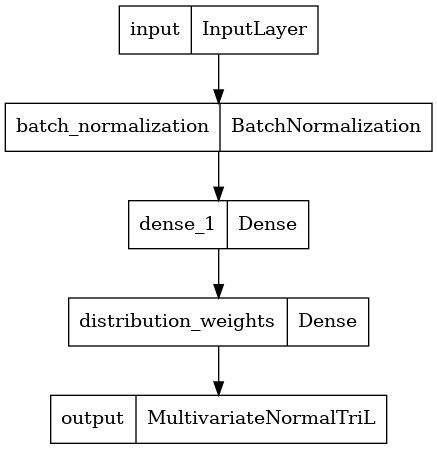

In [35]:
from tensorflow import keras

keras.utils.plot_model(model)

In [36]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=negative_loglikelihood,
    metrics=[keras.metrics.RootMeanSquaredError()],
)

In [39]:
hist = model.fit(
    x=D_tr,
    validation_data=D_te,
    epochs=1_000, 
    verbose=0
)

In [40]:
_, mae_tr = model.evaluate(D_tr, verbose=0)
_, mae_te = model.evaluate(D_te, verbose=0)

print(f'mae_tr: {round(mae_tr, 3)}, mae_te: {round(mae_te, 3)}')

mae_tr: 24.07, mae_te: 21.912
